# Southern Women Dataset
## Hierarchical clustering and polarisation evaluation in bimodal networks
### Use case 1: Validation
#### Adrián Fernández Cid

In this notebook I present an analysis of the Southern Women dataset [1] following the proposal of my master thesis. The purpose of such an analysis is to illustrate in detail and validate to some extent the methods used in the application use case (see *ConferenceOnTheFutureOfEurope.ipynb*).

The Southern Women (henceforth SW) dataset is a table containing binary values encoding the attendance (or absence thereof) of 18 women to a series of 14 social events (a card party, a club meeting, etc.) that took place throughout a year, originally compiled [1] with the purpose of determining the influence of social status on the forming of communities. Although not apparent from the beginning, two groups of women became distinguishable in the reapraisals of [2] and, in an alternative, more straigthforward way, of [3].

The SW has since become a standard dataset in computational social science, namely for testing clustering/community-detection methods in bimodal networks, and is easily available on the usual network repositories (see, for instance, [4]).

**References**

[1] Davis, A., Gardner, B. B., Gardner, M. R., & In Warner, W. L. (1941). "Deep South: A social anthropological study of caste and class". Chicago, Ill: The University of Chicago Press.

[2] Homans, George C. (1950). "The Human Group". New York: Harcourt, Brace & World.

[3] Breiger R. (1974). "The duality of persons and groups". Social Forces, 53, 181-190.

[4] http://casos.cs.cmu.edu/computational_tools/datasets/external/davis/index2.html.

[5] Esteban, J., & Ray, D. (1994). "On the Measurement of
            Polarization". Econometrica, 62(4), 819- 851.

[6] Daniel Mullner (2011), "Modern hierarchical, agglomerative clustering algorithms". arXiv:`1109.2378v1`.



In [1]:
# !jt -t chesterish  # set given theme
#!jt -r # reset default theme

## Outline
### 1. Data & bimodal network
### 2. Clustering & polarisation
#### 2.1. Distance matrix
#### 2.2. Ward
#### 2.3. Centroid
#### 2.4. Poldist
#### 2.5. Evolution with $\alpha$
##### 2.5.1.  Of  tree topology (poldist)
##### 2.5.2. Of polarisation
### 3. Evaluation
#### 3.1. Clustering
#### 3.2. Polarisation


## 1. Data & bimodal network

Let us load and check the data:

In [2]:
import xml.etree.ElementTree as ET
tree = ET.parse('../data/SW/SouthernWomen.xml')
root = tree.getroot()

In [3]:
#recursively check all (*) elements in tree and print 
#their tag and atribute
for element in root.iter('*'): 
    print(element.tag, element.attrib)

DynamicMetaNetwork {'id': 'davis'}
MetaNetwork {'id': 'davis'}
nodes {}
nodeclass {'type': 'Agent', 'id': 'agent'}
node {'id': 'EVELYN'}
node {'id': 'LAURA'}
node {'id': 'THERESA'}
node {'id': 'BRENDA'}
node {'id': 'CHARLOTTE'}
node {'id': 'FRANCES'}
node {'id': 'ELEANOR'}
node {'id': 'PEARL'}
node {'id': 'RUTH'}
node {'id': 'VERNE'}
node {'id': 'MYRNA'}
node {'id': 'KATHERINE'}
node {'id': 'SYLVIA'}
node {'id': 'NORA'}
node {'id': 'HELEN'}
node {'id': 'DOROTHY'}
node {'id': 'OLIVIA'}
node {'id': 'FLORA'}
nodeclass {'type': 'Event', 'id': 'event'}
node {'id': 'E1'}
node {'id': 'E2'}
node {'id': 'E3'}
node {'id': 'E4'}
node {'id': 'E5'}
node {'id': 'E6'}
node {'id': 'E7'}
node {'id': 'E8'}
node {'id': 'E9'}
node {'id': 'E10'}
node {'id': 'E11'}
node {'id': 'E12'}
node {'id': 'E13'}
node {'id': 'E14'}
networks {}
network {'sourceType': 'Agent', 'source': 'agent', 'targetType': 'Event', 'target': 'event', 'id': 'agent x event'}
link {'source': 'EVELYN', 'target': 'E1'}
link {'source': 'EV

Retrieve nodes (women and events):

In [4]:
nodes = []
for node in root.iter('node'): 
    nodes.append(node.attrib["id"])

In [5]:
print(nodes)
women = nodes[:18]
events = nodes[18:]

['EVELYN', 'LAURA', 'THERESA', 'BRENDA', 'CHARLOTTE', 'FRANCES', 'ELEANOR', 'PEARL', 'RUTH', 'VERNE', 'MYRNA', 'KATHERINE', 'SYLVIA', 'NORA', 'HELEN', 'DOROTHY', 'OLIVIA', 'FLORA', 'E1', 'E2', 'E3', 'E4', 'E5', 'E6', 'E7', 'E8', 'E9', 'E10', 'E11', 'E12', 'E13', 'E14']


Women-events network:

In [6]:
import networkx as nx

B = nx.Graph()
# Add nodes with the node attribute "bipartite"
B.add_nodes_from(events, bipartite=0)
B.add_nodes_from(women, bipartite=1)

#add edges
for link in root.iter('link'): 
    source = link.attrib["source"]
    target = link.attrib["target"]
    B.add_edge(source, target)

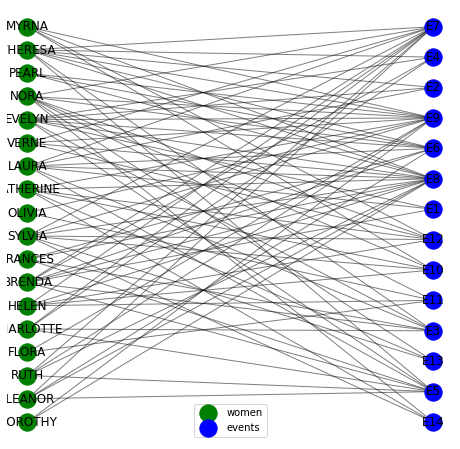

In [7]:
import matplotlib.pyplot as plt

#pos = nx.fruchterman_reingold_layout(B);
pos = nx.drawing.layout.bipartite_layout(B, women);
plt.figure(figsize=(8,8));
plt.axis("off");
nx.draw_networkx_nodes(women, pos, node_size=300, node_color="green", label="women");
nx.draw_networkx_nodes(events, pos, node_size=300, node_color="blue", label="events");
nx.draw_networkx_edges(B, pos, alpha=0.500);
#scatterpoints is the number of points of each colour in legend
nx.draw_networkx_labels(B, pos, font_color="black");
plt.legend(scatterpoints = 1)
plt.savefig("../plots/SW/SW_Net.png")
plt.show()

## 2.  Clustering & polarisation

### 2.1. Distance matrix

Our hierarchical clustering algorithm takes as input a distance matrix in condensed format. We want to build it from the $\phi$ correlation (a.k.a. the Matthews coefficient), which is defined as

$$
\phi (v_1, v_2) = \frac{f_{11}f_{00}-f_{10}f_{01}}{\sqrt{f_{1*}f_{0*}f_{*1}f_{*0}}} = \frac{f_{11}F-f_{1*}f_{*1}}{\sqrt{f_{1*}f_{0*}f_{*1}f_{*0}}}
$$

for any pair of binary vectors $v_1$, $v_2$, where $F$ is the total number of observations, $f_{11}$ is the number of coincidental positive (1) observations, $f_{10}$ that of positive observations for $v_1$ that are also negative (0) for $v_2$, $f_{1*}$ the total of positive observations in $v_1$ regardless of $v_2$, and so on.

Note that $\phi \in [-1, 1]$, the minimum being attained when $f_{11} = f_{00} = 0$ and the maximum when $f_{10} = f_{01} = 0$ (this is apparent in the first definition).

The observation vectors, in this case, correspond to the women, and they contain their attendance values (yes: 1, no: 0) to each event. $F$ will therefore be the number of events (14).

As can be seen above, the $\phi$ coefficient is a way to have some weighting of links in the final distances, which can be obtained from $\phi$ as:

$$
d = \sqrt{2(1-\phi)}
$$


Let us start. First, we define a dictionary containing all events each of the women attended:

In [8]:
wom2eve = {w:[] for w in women}
for link in root.iter('link'): 
    source = link.attrib["source"]
    target = link.attrib["target"]
    wom2eve[source].append(target)
wom2eve

{'EVELYN': ['E1', 'E2', 'E3', 'E4', 'E5', 'E6', 'E8', 'E9'],
 'LAURA': ['E1', 'E2', 'E3', 'E5', 'E6', 'E7', 'E8'],
 'THERESA': ['E2', 'E3', 'E4', 'E5', 'E6', 'E7', 'E8', 'E9'],
 'BRENDA': ['E1', 'E3', 'E4', 'E5', 'E6', 'E7', 'E8'],
 'CHARLOTTE': ['E3', 'E4', 'E5', 'E7'],
 'FRANCES': ['E3', 'E5', 'E6', 'E8'],
 'ELEANOR': ['E5', 'E6', 'E7', 'E8'],
 'PEARL': ['E6', 'E8', 'E9'],
 'RUTH': ['E5', 'E7', 'E8', 'E9'],
 'VERNE': ['E7', 'E8', 'E9', 'E12'],
 'MYRNA': ['E8', 'E9', 'E10', 'E12'],
 'KATHERINE': ['E8', 'E9', 'E10', 'E12', 'E13', 'E14'],
 'SYLVIA': ['E7', 'E8', 'E9', 'E10', 'E12', 'E13', 'E14'],
 'NORA': ['E6', 'E7', 'E9', 'E10', 'E11', 'E12', 'E13', 'E14'],
 'HELEN': ['E7', 'E8', 'E10', 'E11', 'E12'],
 'DOROTHY': ['E8', 'E9'],
 'OLIVIA': ['E9', 'E11'],
 'FLORA': ['E9', 'E11']}

Now, we define a dictionary containing the binary feature vector corresponding to each woman.

Although we could apply the same treatment event-wise, from a conceptual (social) perspective it is more interesting to do it for women (even if the two communities are there in either case).

In [9]:
import numpy as np

n_events = len(events)
wom2vec = {w:[0]*n_events for w in women}
for w in women:
    for i, e in enumerate(events):
        #print(i, e)
        if e in wom2eve[w]:
            wom2vec[w][i] = 1
wom2vec

{'EVELYN': [1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0],
 'LAURA': [1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0],
 'THERESA': [0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0],
 'BRENDA': [1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0],
 'CHARLOTTE': [0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0],
 'FRANCES': [0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0],
 'ELEANOR': [0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0],
 'PEARL': [0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0],
 'RUTH': [0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0],
 'VERNE': [0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0],
 'MYRNA': [0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0],
 'KATHERINE': [0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1],
 'SYLVIA': [0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1],
 'NORA': [0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1],
 'HELEN': [0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0],
 'DOROTHY': [0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0],
 'OLIVIA': [0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0],
 'FLORA': [0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0]}

We now define the distance matrix between women. As already mentioned, we consider their pairwise $\phi$ correlation (using the previously defined dictionary **wom2vec**), which we later turn into a Euclidean distance.

We can implement $\phi$ easily (I use its second definition below):

In [10]:
#compute phi correlation of two list binary (0s and 1s) vectors 
def phi_corr(v1, v2):
    N = len(v1)
    v1 = np.array(v1)
    v2 = np.array(v2)
    n1p = np.sum(v1)
    n2p = np.sum(v2)
    s = (v1+v2)/2
    n11 = np.sum(s[s==1])
    #print(n1p, n11, N)
    return (n11*N-n1p*n2p)/np.sqrt(n1p*n2p*(N-n1p)*(N-n2p))

Scikit-learn provides a function for computing the $\phi$, *matthews_corrcoef*, that is presumably faster than our "handmade" implementation. Let's check both to see they give the same result and which is faster.

We define a function to compute the condensed distance matrix:

In [11]:
from sklearn.metrics import matthews_corrcoef

#build normalised condensed distance matrix
def cond_dist_matrix(x, x2vec, use_sklearn_phi=False):
    phi = []
    nx = len(x)
    for i, xi in enumerate(x):
        vec_xi = x2vec[xi]
        for j in range(i+1, nx):
            vec_xj = x2vec[x[j]]  
            if use_sklearn_phi:
                phi.append(matthews_corrcoef(vec_xi, vec_xj))
            else:
                phi.append(phi_corr(vec_xi, vec_xj))
    #print(min(phi), max(phi))
    #check the length of phi is what we expect,  n(n-1)/2
    if len(phi) != nx*(nx-1)/2:
        raise ValueError("The dimensions of the condensed distance matrix are wrong.")
    #turn correlations to Euclidean distances (the phi are somewhat like the cosine)
    d = np.sqrt(2*(1-np.array(phi)))
    #normalise d to 1
    d /= max(d)
    return d

In [12]:
d = cond_dist_matrix(women, wom2vec)
#dfile = "../data/SW/d_SouthernWomen.npy"
#np.save(dfile, d)
d2 = cond_dist_matrix(women, wom2vec, use_sklearn_phi=True)
np.isclose(d, d2).all()

True

Both functions do give the same result. Let's now see which is faster:

In [14]:
%timeit cond_dist_matrix(women, wom2vec)

9.65 ms ± 395 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [15]:
%timeit cond_dist_matrix(women, wom2vec, use_sklearn_phi=True)

176 ms ± 10.9 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


Wow! It seems our implementation is actually faster than Scikitk-learn's after all. We'll stick to it, then.

We are now ready to apply the clustering and measure polarisation.

### 2.2. Ward

 We start with the Ward distance update scheme. Since our algorithm has been adapted from the Scipy method, it is good to check it works the way it does with Scipy.
 
 The Scipy method gives:

In [13]:
#import numpy as np
#import matplotlib.pyplot as plt

#dfile = "../data/SW/d_SouthernWomen.npy"
#d = np.load(dfile)

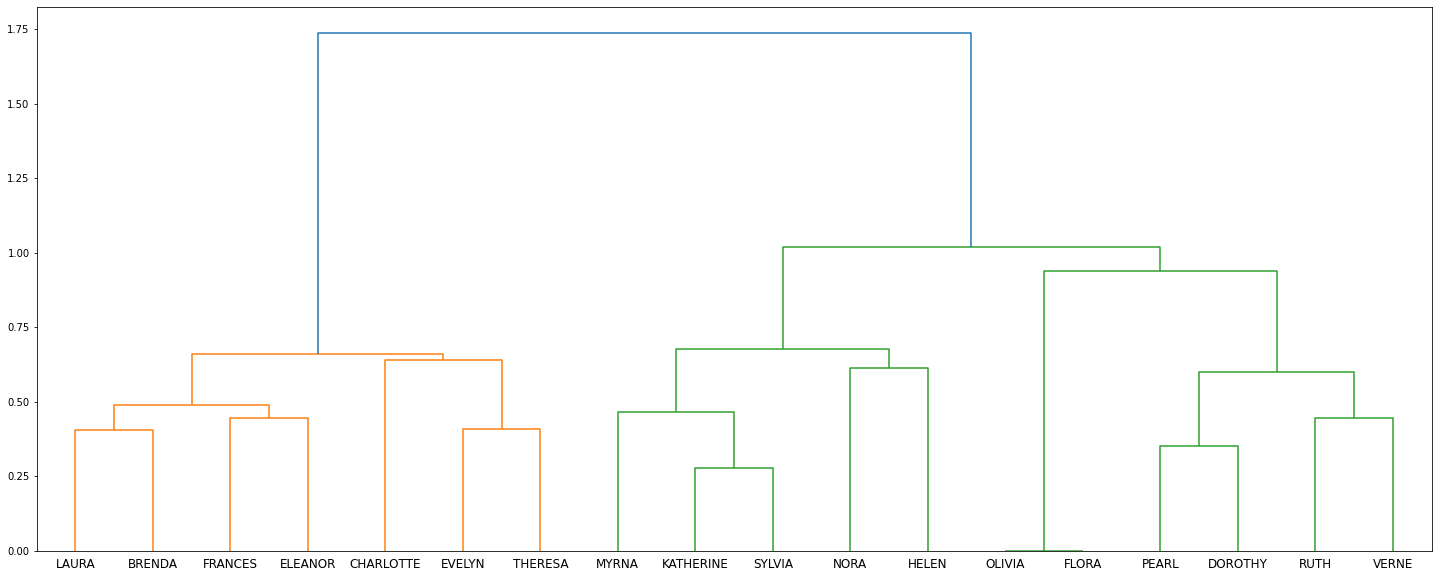

In [14]:
from scipy.cluster.hierarchy import dendrogram, linkage

z_sc = linkage(d, 'ward')
fig = plt.figure(figsize=(25, 10))
dn = dendrogram(z_sc, labels=women)
plt.show()

In [15]:
z_sc

array([[16.        , 17.        ,  0.        ,  2.        ],
       [11.        , 12.        ,  0.2766892 ,  2.        ],
       [ 7.        , 15.        ,  0.35316046,  2.        ],
       [ 1.        ,  3.        ,  0.40406102,  2.        ],
       [ 0.        ,  2.        ,  0.40824829,  2.        ],
       [ 5.        ,  6.        ,  0.4472136 ,  2.        ],
       [ 8.        ,  9.        ,  0.4472136 ,  2.        ],
       [10.        , 19.        ,  0.46609234,  3.        ],
       [21.        , 23.        ,  0.48828083,  4.        ],
       [20.        , 24.        ,  0.59999298,  4.        ],
       [13.        , 14.        ,  0.61213202,  2.        ],
       [ 4.        , 22.        ,  0.64090007,  3.        ],
       [26.        , 29.        ,  0.66025877,  7.        ],
       [25.        , 28.        ,  0.67855153,  5.        ],
       [18.        , 27.        ,  0.9386196 ,  6.        ],
       [31.        , 32.        ,  1.01900634, 11.        ],
       [30.        , 33.

The above plot looks ok, but we can make it even more informative by coupling it to a heatmap of the distance matrix:

In [16]:
from scipy.spatial.distance import squareform
import pandas as pd

d_sq = squareform(d)
d_df = pd.DataFrame(d_sq, index=women, columns=women)
#d_df.head()

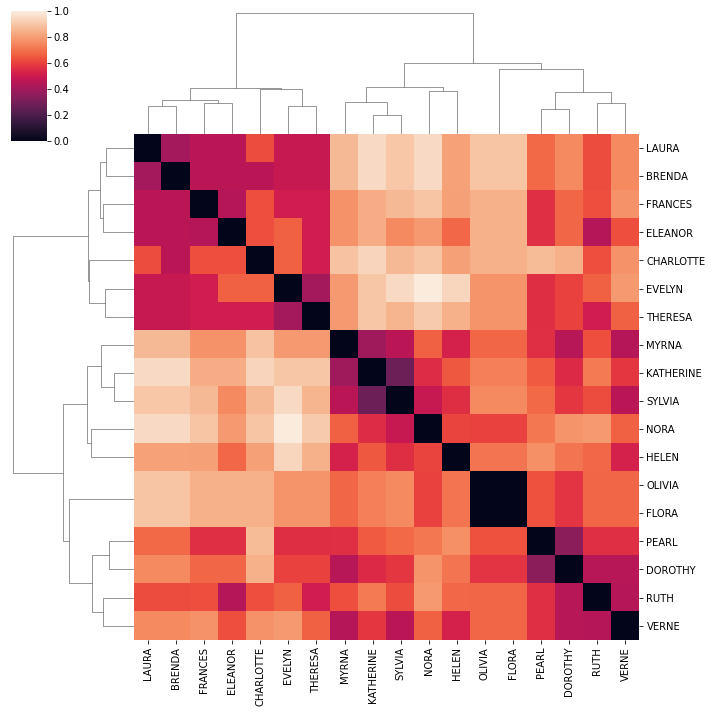

In [17]:
import seaborn as sns

sns.clustermap(d_df, row_linkage=z_sc, col_linkage=z_sc)
plt.show()

Better!

Let's see what our method gives with Ward clustering. Note that it is a bit different: take a minute to read the its help page. 

In [18]:
#for importing from parent directory
import os,sys,inspect
currentdir = os.path.dirname(os.path.abspath(inspect.getfile(inspect.currentframe())))
parentdir = os.path.dirname(currentdir)
sys.path.insert(0,parentdir) 

In [19]:
from utils.clustering import agglomerative_clustering

help(agglomerative_clustering)

Help on function agglomerative_clustering in module utils.clustering:

agglomerative_clustering(y, method='ward', alpha=1, K=None, verbose=0, algorithm='generic')
    Perform hierarchical, agglomerative clustering on given
    condensed distance matrix y. Adapted (as well as the
    auxiliary functions, excepting compute_polarisation)
    from Scipy's 'linkage' method [1] and the main reference
    therein [2].
    
    Parameters
    ----------
    y : ndarray
        A condensed matrix containing the pairwise distances of
        the observations.
    method : str, optional
        The distance update scheme: "ward" (the default), "centroid"
        or "poldist".
    alpha : double, optional
        Value of the `polarisation sensitivity` parameter [3], only
        used for computing polarisation and, if method="poldist",
        distance update. Default is alpha=1.
    K : double, optional
        Normalisation factor used for computing the polarisation [3].
        If none is spec

Iteration 15/16...
Cluster 6 (size 7) and cluster 14 (size 5) have dist 1.75
Cluster 6 (size 7) and cluster 17 (size 6) have dist 1.38
Cluster 14 (size 5) and cluster 17 (size 6) have dist 1.02
and total polarisation is 0.51
Iteration 16/16...
Cluster 6 (size 7) and cluster 17 (size 11) have dist 1.74
and total polarisation is 0.56


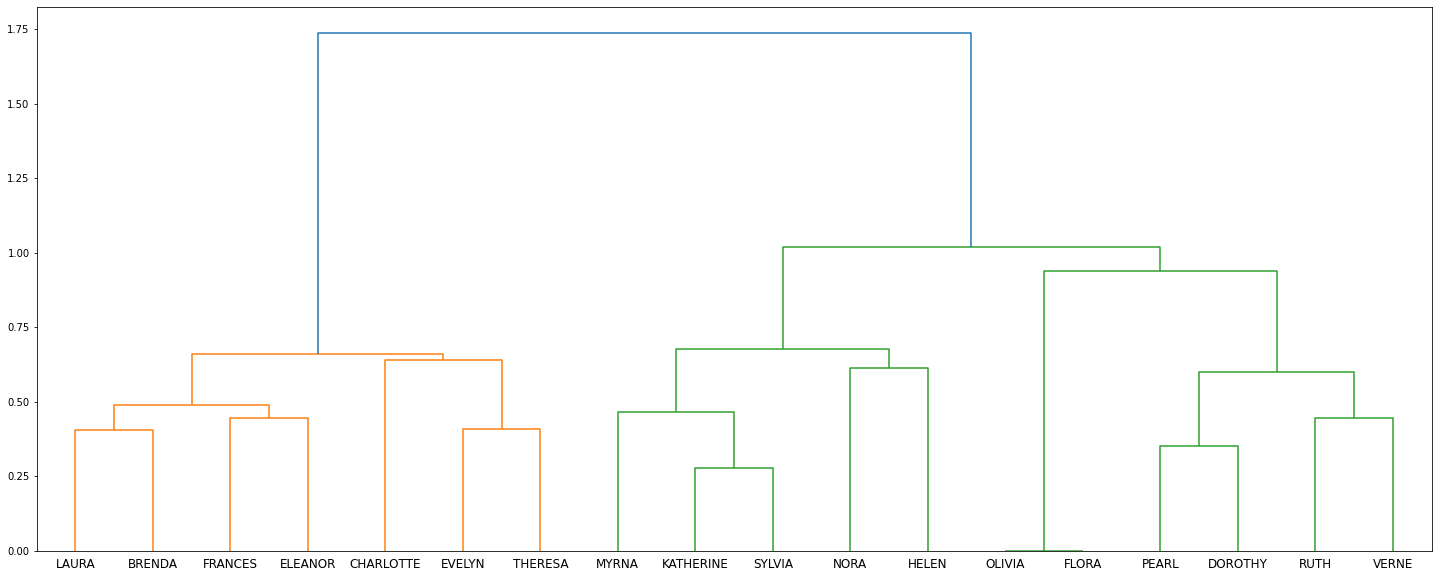

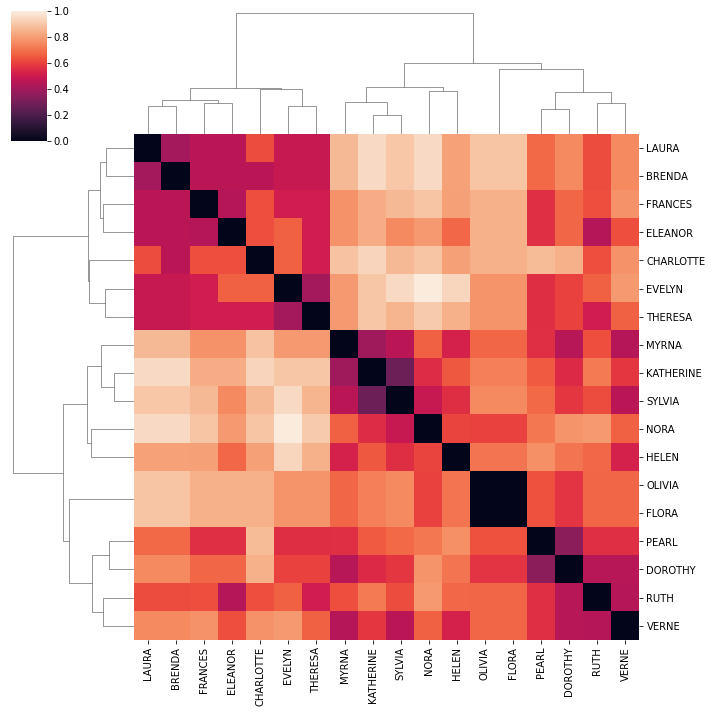

In [20]:
z_wrd, pol_wrd = agglomerative_clustering(d, method='ward',
                                    verbose=1, algorithm="nn_chain")

fig = plt.figure(figsize=(25, 10))
dn = dendrogram(z_wrd, labels=women)
sns.clustermap(d_df, row_linkage=z_wrd, col_linkage=z_wrd)
plt.savefig("../plots/SW/SW_TreeWard.png")
plt.show()

In [21]:
z_wrd, np.round(pol_wrd, 2)

(array([[16.        , 17.        ,  0.        ,  2.        ],
        [11.        , 12.        ,  0.2766892 ,  2.        ],
        [ 7.        , 15.        ,  0.35316046,  2.        ],
        [ 1.        ,  3.        ,  0.40406102,  2.        ],
        [ 0.        ,  2.        ,  0.40824829,  2.        ],
        [ 5.        ,  6.        ,  0.4472136 ,  2.        ],
        [ 8.        ,  9.        ,  0.4472136 ,  2.        ],
        [10.        , 19.        ,  0.46609234,  3.        ],
        [21.        , 23.        ,  0.48828083,  4.        ],
        [20.        , 24.        ,  0.59999298,  4.        ],
        [13.        , 14.        ,  0.61213202,  2.        ],
        [ 4.        , 22.        ,  0.64090007,  3.        ],
        [26.        , 29.        ,  0.66025877,  7.        ],
        [25.        , 28.        ,  0.67855153,  5.        ],
        [18.        , 27.        ,  0.9386196 ,  6.        ],
        [31.        , 32.        ,  1.01900634, 11.        ],
        

The dendograms look quite the same, and the linkage matrices are indeed identical:

In [22]:
np.isclose(z_wrd,z_sc).all()

True

Plus, our method also computes the global polarisation $P$ (or $pol$ above) at every step (except when there is only one cluster, because the polarisation of such a system is null). The formula [5] is:

$$P = K  \sum_{i=1}^{N_c}  \sum_{j=1}^{N_c} n_i^{1+\alpha}n_j  d_c(i,j)  $$

where $\alpha \in (0,1.6]$ is the *polarisastion sensitivity* parameter, $n_i$ is the size of cluster $i$, $N_c$ the total number of clusters and $d_c(i, j)$ is the centroid distance between $i$ and $j$. $K$ is a normalisation constant, that we take as $K = (2/N)^{\alpha + 2}/2$: the inverse of the maximum unnormalised polarisation for a given population of $N$ initial points (in this case, the $18$ women) with distance normalised to $1$, i.e. with half the population on each of two extrema separated by $d_c=1$ [5]. We therefore have $P\in [0, 1]$.

The polarisation with Ward clustering is:

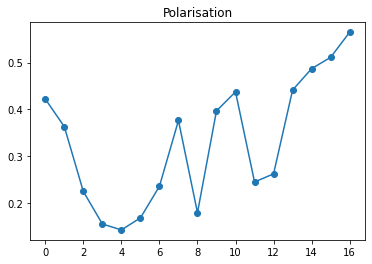

In [23]:
from matplotlib import pyplot as plt

plt.plot(pol_wrd, "-o")
plt.title("Polarisation")
plt.show()

Quite wobbly! Let's see what we get with the centroid distance update scheme.

### 2.3. Centroid

Our method gives:

Iteration 15/16...
Cluster 6 (size 7) and cluster 15 (size 9) have dist 0.59
Cluster 6 (size 7) and cluster 17 (size 2) have dist 0.77
Cluster 15 (size 9) and cluster 17 (size 2) have dist 0.55
and total polarisation is 0.55
Iteration 16/16...
Cluster 6 (size 7) and cluster 17 (size 11) have dist 0.59
and total polarisation is 0.56


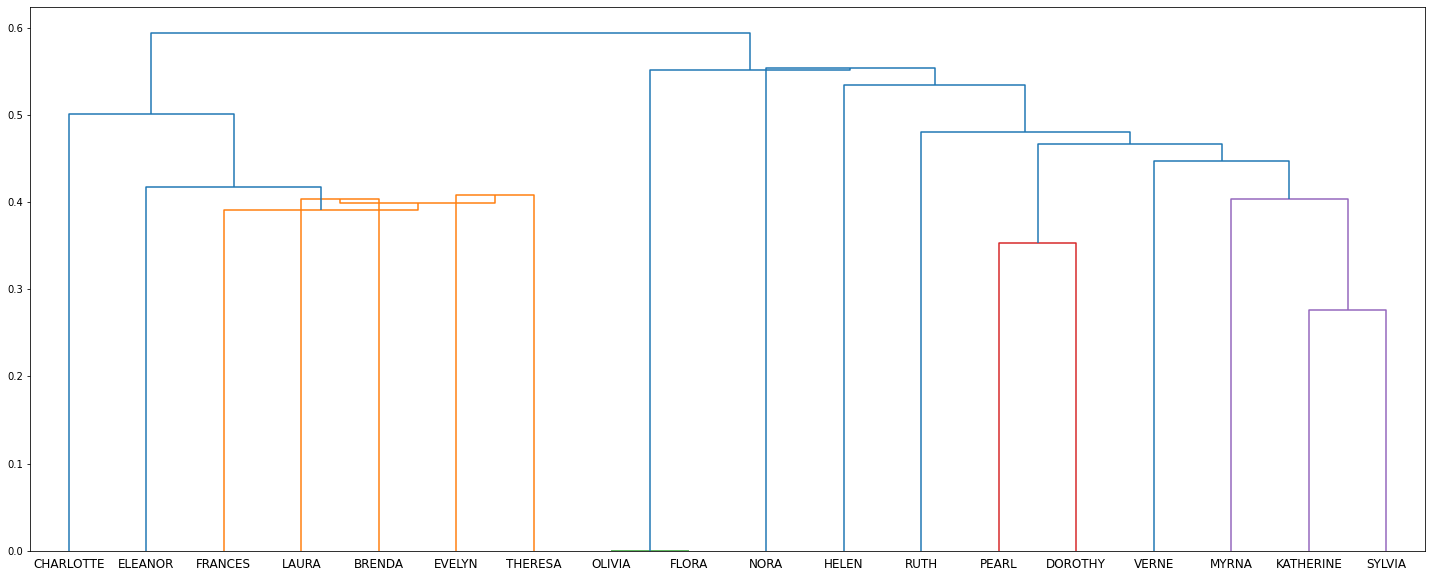

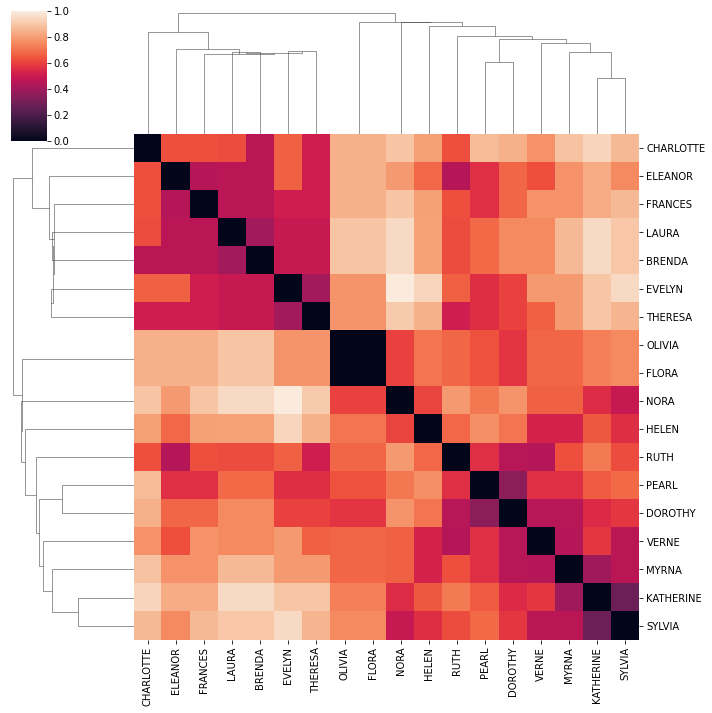

In [24]:
from scipy.cluster.hierarchy import dendrogram
from utils.clustering import agglomerative_clustering

z_ctr, pol_ctr = agglomerative_clustering(d, method='centroid'
                                      , alpha=1, K=None
                                     , verbose=1, algorithm="generic")

fig = plt.figure(figsize=(25, 10))
dn = dendrogram(z_ctr, labels=women)
sns.clustermap(d_df, row_linkage=z_ctr, col_linkage=z_ctr)
plt.savefig("../plots/SW/SW_TreeCentroid.png")
plt.show()

Which is, again, the same result as that of Scipy:

In [25]:
z_sc = linkage(d, 'centroid')
np.isclose(z_ctr, z_sc).all()

True

Note the inversion in the yellow branch of the left cluster: indeed, the centroid update scheme allows for such a behaviour, whereas Ward's does not [6]. Incidentally, that is also the reason why the *nn_chain* algorithm does not produce a valid solution for the centroid method.

Regarding the polarisation, in this case it is monotonically increasing with the clustering step:

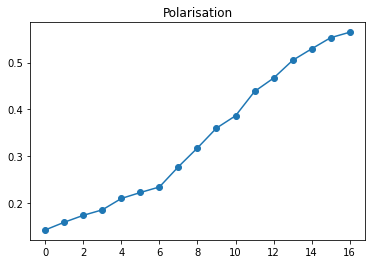

In [26]:
plt.plot(pol_ctr, "-o")
plt.title("Polarisation")
plt.show()

Note that our method gives an error if one tries to use the *nn_chain* algorithm with the *centroid* method:

In [27]:
z_ctr, pol_ctr = agglomerative_clustering(d, method='centroid'
                                     , algorithm="nn_chain")

ValueError: The nn_chain algorithm cannot be used with the centroid nor poldist methods. Use algorithm='generic' instead.

### 2.4. Poldist

Let's now see what we get when using the polarisation distance (*poldist*), inspired from the polarisation formula in [5], as the clustering criterion. 

The *poldist* between clusters $u$ and $v$ is given by:

$$d(i,j) = K d_c(i,j)(n_i^{1+\alpha}n_j + n_j^{1+\alpha}n_i)$$

where, as in the polarisation formula, we take $K = (2/N)^{\alpha + 2}/2$,  $\alpha \in (0,1.6]$, $n_i$ is the size of cluster $i$ and $d_c(i,j)$ is the centroid distance between $i$ and $j$.

Note that the above expression is just centroid distance weighted by a function of cluster sizes, much like the Ward formula. In this case, however, we see that such a function makes *poldist* clustering favour smaller sizes: at any given step, the algorithm will tend to merge smaller clusters, making the resulting tree more "balanced".

Another feature of the *poldist* formula is that it coincides (up to a normalisation constant) with global polarisation when there are only two clusters (e.g. at the last step of the clustering).

Iteration 15/16...
Cluster 6 (size 6) and cluster 15 (size 8) have dist 0.27
Cluster 6 (size 6) and cluster 17 (size 4) have dist 0.1
Cluster 15 (size 8) and cluster 17 (size 4) have dist 0.12
and total polarisation is 0.49
Iteration 16/16...
Cluster 15 (size 8) and cluster 17 (size 10) have dist 0.44
and total polarisation is 0.44


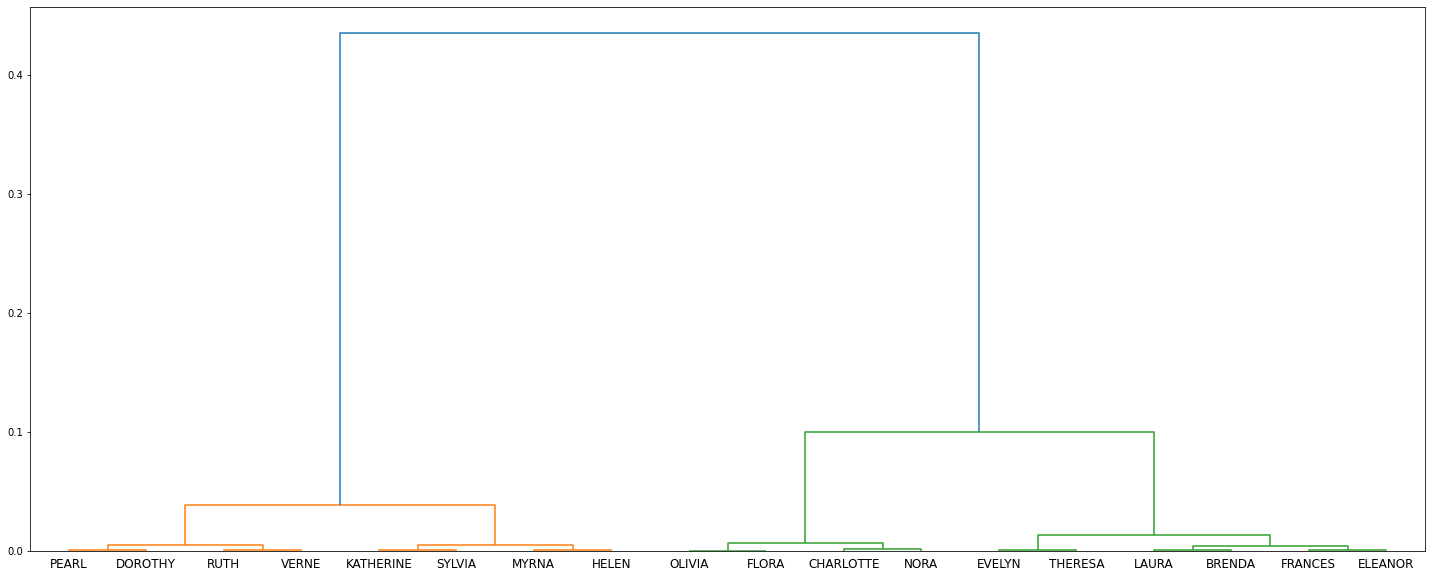

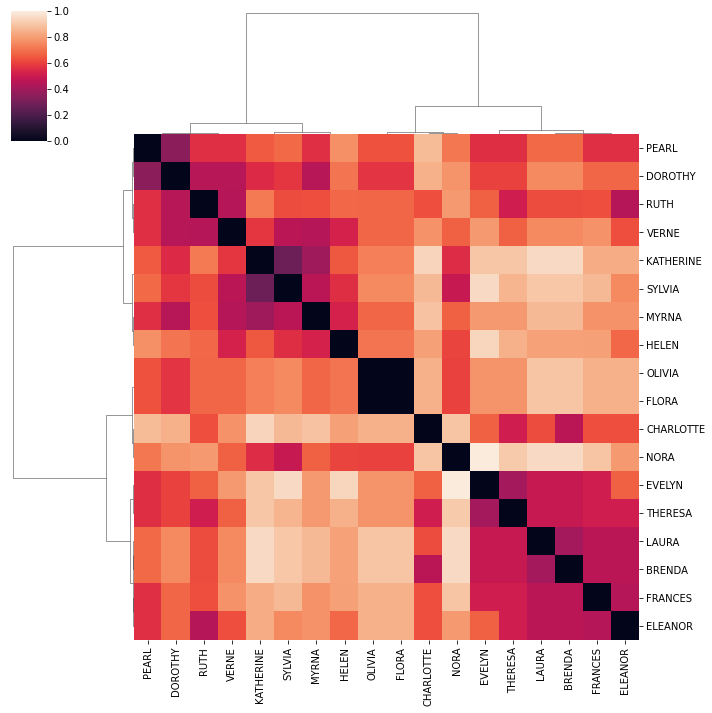

In [28]:
z_pld, pol_pld = agglomerative_clustering(d, method='poldist'
                                      , verbose=1, algorithm="generic")

fig = plt.figure(figsize=(25, 10))
dn = dendrogram(z_pld, labels=women)
sns.clustermap(d_df, row_linkage=z_pld, col_linkage=z_pld)
plt.savefig("../plots/SW/SW_TreePoldist.png")

plt.show()

Indeed, we see that the tree is quite balanced. Another feature resulting from the weighting function in *poldist* is that all distances increase appreciatively as clustering progresses, vertically stretching succesive junctions.

The polarisation is:

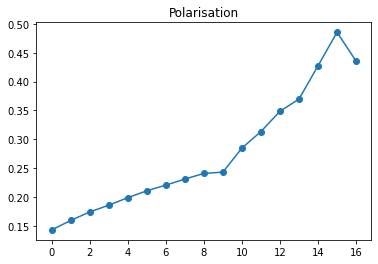

In [29]:
plt.plot(pol_pld, "-o")
plt.title("Polarisation")
plt.show()

Note that, as we might expect, polarisation seems to increase more or less monotonically when clustering by polarisation distance. Remarkably though, the most polarised state is not the last one (with only 2 clusters) but the previous one (with 3): this makes sense when checking via the last distances (poldists, in this case) and sizes, conveniently printed by the algorithm when the *verbose* is set to $1$. 

When considering the network of events instead of that of women, the last state (with 2 clusters), is indeed the one with greater polarisation.

One can also conceive of using the *nn_chain* algorithm with the *poldist* method, but as with the *centroid* method such a combination does not in general produce valid results: it does find an equivalent solution for this dataset, but not in general (e.g. for the CFE dataset it produces an incompatible result with proposals on "Security"). Therefore, we also forbid such a combination:

In [30]:
z_pld, pol_pld = agglomerative_clustering(d, method='poldist', algorithm="nn_chain")

ValueError: The nn_chain algorithm cannot be used with the centroid nor poldist methods. Use algorithm='generic' instead.

### 2.5. Evolution with $\alpha$

#### 2.5.1.  Of  tree topology (*poldist*)

Let's check the tree distance between our results for the *Ward*, *poldist* and *centroid* methods. We will use the Robinson-Foulds (RF) metric, which is a sort of edit distance for trees: the RF distance between two trees is defined as the sum of the number of junctions that appear in only one of them.

We will use the library *dendropy*, which conveniently implements such a metric.

In [31]:
#!pip install dendropy

Function to produce tree string in Newick format (one format accepted by *dendropy*) from a linkage matrix:

In [32]:
import dendropy

def z_to_tree_str_newick(z):
    tree_str = ""
    clusters = women
    idx2woman = {i:wi for i, wi in enumerate(women)}
    woman2idx = {wi:i for i, wi in enumerate(women)}
    n = z.shape[0] + 1
    for i in range(n-1):
        #print(z[i, :2])
        new_clus = "(" + idx2woman[int(z[i,0])] + "," + idx2woman[int(z[i,1])] + ")"
        idx2woman[int(i+n)] = new_clus
        #print(int(i+z.shape[0]))
    #the "[&R]" specifies that the tree is rooted
    idx2woman[int(2*n-2)] = "[&R] " + idx2woman[int(2*n-2)] + ";"
    return idx2woman[int(2*n-2)]

tree_str_ctr = z_to_tree_str_newick(z_ctr)
tree_str_wrd = z_to_tree_str_newick(z_wrd)

print(f"{tree_str_ctr}\n{tree_str_wrd}")

[&R] ((CHARLOTTE,(ELEANOR,(FRANCES,((LAURA,BRENDA),(EVELYN,THERESA))))),((OLIVIA,FLORA),(NORA,(HELEN,(RUTH,((PEARL,DOROTHY),(VERNE,(MYRNA,(KATHERINE,SYLVIA)))))))));
[&R] ((((LAURA,BRENDA),(FRANCES,ELEANOR)),(CHARLOTTE,(EVELYN,THERESA))),(((MYRNA,(KATHERINE,SYLVIA)),(NORA,HELEN)),((OLIVIA,FLORA),((PEARL,DOROTHY),(RUTH,VERNE)))));


Function to compute the (unweighted) Robinson-Foulds distance between two trees given their strings in Newick format:

In [33]:
import dendropy
from dendropy.calculate import treecompare
def RF_dist(tree_str1, tree_str2):
    # trees need to have the same TaxonNamespace for RF distance
    tns = dendropy.TaxonNamespace()
    tree1 = dendropy.Tree.get_from_string(tree_str1, "newick",
            taxon_namespace=tns)
    tree2 = dendropy.Tree.get_from_string(tree_str2, "newick",
            taxon_namespace=tns)
    #have to compute bipàrtitions of both trees 
    #before calling symmetric_difference
    tree1.encode_bipartitions()
    tree2.encode_bipartitions()
    #return unweighted RF distance
    return treecompare.symmetric_difference(tree1, tree2)

Let's make a quick check to get the idea of how this works. One can quickly see that it takes 4 steps (removing or adding one junction at a time) to go from *tree1* to *tree2*, or vice versa, below:

In [34]:
tree1_str = "[&R] (((A, B), C),(D,E));"
tree1 = dendropy.Tree.get_from_string(tree1_str, "newick")
print(tree1.as_ascii_plot())
tree2_str = "[&R] ((A, B), ((C, D),E));"
tree2 = dendropy.Tree.get_from_string(tree2_str, "newick")
print(tree2.as_ascii_plot())

RF_dist(tree1_str, tree2_str)

                                                   /------------------------- A
                         /-------------------------+                           
/------------------------+                         \------------------------- B
|                        |                                                     
+                        \--------------------------------------------------- C
|                                                                              
|                                                  /------------------------- D
\--------------------------------------------------+                           
                                                   \------------------------- E
                                                                               
                                                                               
                                                   /------------------------- A
/---------------------------------------

4

We can try it on the *Ward* and *centroid* trees:

In [35]:
RF_dist(tree_str_wrd, tree_str_ctr)

16

They are quite different. 

Regarding *poldist*, since the trees produced with it may vary with polarisation sensitivity $\alpha$, for such a method we compute the RF distances to the other two considering different values of the parameter:

In [36]:
#produce RF distances vs alpha
dist_p2c = []
dist_p2w = []
dist_p2p0 = []
#alphas = np.arange(0,50,1)
#alphas = np.arange(0,20,1)
alphas = np.logspace(-1, 1, 20)#from 1e-1 to 1e1

z_pld0, _ = agglomerative_clustering(d, method='poldist'
                                          , alpha=0)
tp0_str = z_to_tree_str_newick(z_pld0)

for alpha in alphas:
    print(f"***** alpha={round(alpha, 2)} *****")
    z_pld, _ = agglomerative_clustering(d, method='poldist'
                                          , alpha=alpha)
    z_ctr, _ = agglomerative_clustering(d, method='centroid')
    z_wrd, _ = agglomerative_clustering(d, method='ward', algorithm="nn_chain")

    tp_str = z_to_tree_str_newick(z_pld)
    tc_str = z_to_tree_str_newick(z_ctr)
    tw_str = z_to_tree_str_newick(z_wrd)
    
    dist_p2c.append(RF_dist(tp_str, tc_str))
    dist_p2w.append(RF_dist(tp_str, tw_str))
    dist_p2p0.append(RF_dist(tp0_str, tp_str))

Iteration 16/16...
***** alpha=0.1 *****
Iteration 16/16...
Iteration 16/16...
Iteration 16/16...
***** alpha=0.13 *****
Iteration 16/16...
Iteration 16/16...
Iteration 16/16...
***** alpha=0.16 *****
Iteration 16/16...
Iteration 16/16...
Iteration 16/16...
***** alpha=0.21 *****
Iteration 16/16...
Iteration 16/16...
Iteration 16/16...
***** alpha=0.26 *****
Iteration 16/16...
Iteration 16/16...
Iteration 16/16...
***** alpha=0.34 *****
Iteration 16/16...
Iteration 16/16...
Iteration 16/16...
***** alpha=0.43 *****
Iteration 16/16...
Iteration 16/16...
Iteration 16/16...
***** alpha=0.55 *****
Iteration 16/16...
Iteration 16/16...
Iteration 16/16...
***** alpha=0.7 *****
Iteration 16/16...
Iteration 16/16...
Iteration 16/16...
***** alpha=0.89 *****
Iteration 16/16...
Iteration 16/16...
Iteration 16/16...
***** alpha=1.13 *****
Iteration 16/16...
Iteration 16/16...
Iteration 16/16...
***** alpha=1.44 *****
Iteration 16/16...
Iteration 16/16...
Iteration 16/16...
***** alpha=1.83 *****


In [37]:
#dist_p2p0, dist_p2c, dist_p2w

In [38]:
#activate suppression in np's print options to avoid 
#printing large numbers in lengthy scientific notation
np.set_printoptions(suppress=True)
alphas

array([ 0.1       ,  0.1274275 ,  0.16237767,  0.20691381,  0.26366509,
        0.33598183,  0.42813324,  0.54555948,  0.6951928 ,  0.88586679,
        1.12883789,  1.43844989,  1.83298071,  2.33572147,  2.97635144,
        3.79269019,  4.83293024,  6.15848211,  7.8475997 , 10.        ])

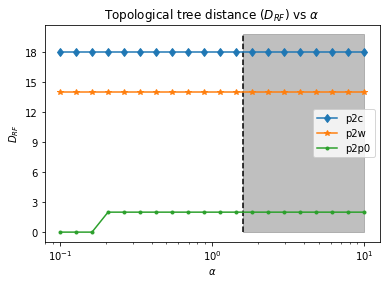

In [39]:
#plot tree distances vs alpha
from matplotlib.ticker import MaxNLocator

ax = plt.figure().gca()
ax.plot(alphas, dist_p2c, "-d", label="p2c")
ax.plot(alphas, dist_p2w, "*-", label="p2w")
ax.plot(alphas, dist_p2p0, ".-", label="p2p0")
plt.xscale("log")
maxd = np.max([dist_p2p0, dist_p2c, dist_p2w])
plt.vlines(1.6, 0, maxd*1.1, colors='k', linestyles='dashed')
plt.fill_betweenx([0, maxd*1.1]
                  , 1.6, np.max(alphas), alpha=0.5
                  , color="gray")

ax.yaxis.set_major_locator(MaxNLocator(integer=True))
plt.title(r"Topological tree distance ($D_{RF}$) vs $\alpha$")
plt.xlabel(r"$\alpha$")
plt.ylabel(r"$D_{RF}$")
plt.legend()
plt.savefig("../plots/SW/SW_RFdistVsAlpha.png")
plt.show()

Looks like, aside from the change from $\alpha \approx 0.16$ to $\alpha \gtrsim 0.21$ (that yields an RF distance of $2$ to the tree obtained with $\alpha = 0$), there seem to be no topological changes in the *poldist* tree for the different $\alpha$ allowed ($\alpha \in (0, 1.6]$, to the left of the vertical line), and not even up to $\alpha=10$. The distances between branches do change (I checked), but the structure is the same. 

Note that renormalising $d_c$ in *poldist* would change nothing, because it's a proportionality constant: the only thing that could presumably make the allowed range of $\alpha$ more relevant for the structure of the *poldist* clustering is a greater network size (which would allow for the forming of greater clusters, thus increasing the contribution of $\alpha$ in the exponent).

#### 2.5.2. Of polarisation

Another thing we can look at is the evolution of the polarisation throughout the clustering for different $\alpha$:

Iteration 16/16...
Iteration 16/16...
Iteration 16/16...
Iteration 16/16...
Iteration 16/16...
Iteration 16/16...
Iteration 16/16...
Iteration 16/16...


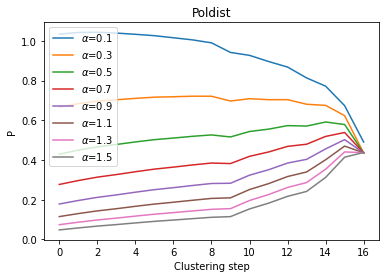

Iteration 16/16...
Iteration 16/16...
Iteration 16/16...
Iteration 16/16...
Iteration 16/16...
Iteration 16/16...
Iteration 16/16...
Iteration 16/16...


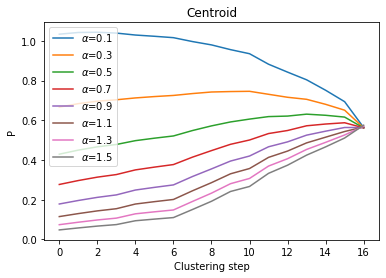

Iteration 16/16...
Iteration 16/16...
Iteration 16/16...
Iteration 16/16...
Iteration 16/16...
Iteration 16/16...
Iteration 16/16...
Iteration 16/16...


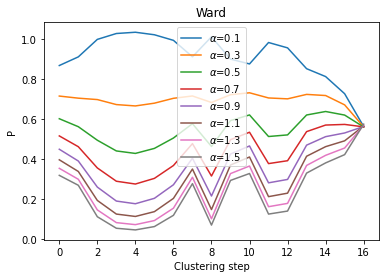

In [40]:
alphas = np.arange(0.1,1.7,0.2)

for method in ["poldist", "centroid", "ward"]:
    algo = "nn_chain" if method == "ward" else "generic"
    for alpha in alphas:
        _, p = agglomerative_clustering(d, method=method
                                        , alpha=alpha, algorithm=algo)
        plt.plot(p, "-", label=r"$\alpha$="+str(round(alpha,1)))
        
    m_name = method[0].upper() + method[1:]
    plt.title(m_name)
    plt.xlabel("Clustering step")
    plt.ylabel("P")
    plt.legend()
    plt.savefig("../plots/SW/SW_Polarisation" + m_name + ".png")
    plt.show()

We observe a convergence in the final state of the clustering for every $\alpha$.

In addition we see that, overall, for low $\alpha$ $P$ starts high and decreases with clustering step, while the behaviour is the opposite for higher values: $\alpha$ starts low and increases. 

This is consistent with the description in the original paper [5]: the polarisation formula reduces to the standard inequality formula for $\alpha \approx 0$, and inequality is generally greater in a system with only point clusters than when they start to merge; on the other hand, the contribution of a non-vanishing $\alpha$ is to allow for intra-group identification to increase inter-group alienation, hence favoring greater cluster sizes. We now have an intuitive grasp of why $\alpha$ is called the *polarisation sensitivity*.

## 3. Evaluation

### 3.1. Clustering 

Davis et al. [1] were not able to determine any meaningful women communities from the women-events network, since nearly all women were connected to each other by attendance to at least one common event (as pointed out by Breiger [3], there are 139 such links from a total of (1/2)(18)(17) = 153 possible ones, which makes a connectivity as high as 91%). 

However, Homans [2] and Breiger [3] do report a specific community structure. Homans finds that by rearranging the woman-event matrix (i.e. the **wom2vec** dictionary defined above) so that women that coincided most often are grouped and events attended by most women are near the center (a tedious approach indeed, considering it had to be done manually at the time) two groups become distinct: one formed by Charlotte, Eleanor, Brenda, Theresa, Evelyn, Laura and Frances; and the other by Nora, Katherine, Helen, Sylvia and Myrna. The rest of the women are considered not to clearly belong to either group.

In the case of Breiger, by eliminating those events connected to every other event by at least one woman (in order to leave only events that help discriminate among women) he finds two groups formed by: Charlotte, Ruth, Eleanor, Brenda, Theresa, Evelyn, Laura and Frances; and Verne, Nora, Flora, Katherine, Olivia, Helen, Sylvia and Myrna. Note that these contain Homans' groups, but add Ruth, Verne, Olivia and Flora, whom Homans judged not to belong to any group.

This means that we have two reference partitions to compare our clustering with. Since we are talking about sets, a good place to start is the **Jaccard distance**.

Jaccard distance is a measure of dissimilarity between sets. For sets $A$ and $B$ it is defined as:

$$
d_J(A,B) = 1 - \frac{| A \cap B |} {| A \cup B |} 
$$

Note however that we don't want to compare two sets, but two *pairs of sets* (the final state of any clustering with either of the partitions obtained by Homans and Breiger). Since our clustering always contains all women, one can argue for using only the set of possible coincidental elements (instead that of all possible elements) in the denominator. Therefore, if we have the pairs $(R_1, R_1)$ and $(C_1, C_2)$, the first being the reference, one way to adapt $d_J$ is:

$$
d^*_J((R_1, R_2), (C_1, C_2)) = 1 - S^*_J ((R_1, R_2), (C_1, C_2)) 
$$
where the *modified Jaccard similarity* $S^*_J$ would be
$$
S^*_J ((R_1, R_2), (C_1, C_2)) = \sigma^{-1} \left[\frac{\text{max}(| R_1 \cap C_1 | + | R_2 \cap C_2 |, | R_1 \cap C_2 | + | R_2 \cap C_1 | )} {| R_1 \cup R_2 |} - \mu\right]
$$

and $\mu$ and $\sigma$ are just to re-center and rescale $S^*_J$ so that it varies between 0 and 1.

We define the modified Jaccard distance:

In [41]:
from math import ceil

def mod_jaccard_distance(c1,c2, case="breiger"):
    den = len(women) - 2
    
    r1 = {'EVELYN','LAURA', 'THERESA', 'BRENDA'
          , 'CHARLOTTE', 'FRANCES', 'ELEANOR', 'RUTH'}# 'PEARL'
    r2 = {'VERNE', 'MYRNA','KATHERINE', 'SYLVIA','NORA'
          ,'HELEN', 'OLIVIA', 'FLORA'}# 'DOROTHY'

    if case == "homans":
        r1.discard('RUTH')
        r2.discard('VERNE')
        r2.discard('OLIVIA')
        r2.discard('FLORA')        
        den -= 4
        
    mu = ceil(den/2)/den
    sigma = 1 - mu
    #print(min_sim, raw_range)
    
    num = max(len(c1.intersection(r1)) + len(c2.intersection(r2))
              , len(c1.intersection(r2)) + len(c2.intersection(r1)))
    
    return 1 - (num/den - mu)/sigma

For the Breiger groups, it should give 0 in both cases:

In [42]:
c1 = {'EVELYN','LAURA', 'THERESA', 'BRENDA'
          , 'CHARLOTTE', 'FRANCES', 'ELEANOR', 'RUTH'}# 'PEARL'
c2 = {'VERNE', 'MYRNA','KATHERINE', 'SYLVIA','NORA'
          ,'HELEN', 'OLIVIA', 'FLORA'}# 'DOROTHY'

In [43]:
mod_jaccard_distance(c2, c1), mod_jaccard_distance(c2, c1, "homans")

(0.0, 0.0)

Alright! We also need to access the final partition of the clustering. We could just inspect the corresponding heatmap, but we can also do it automatically by defining a function that takes a linkage matrix and returns the cluster configuration at a given step (by default, the last):

In [44]:
def z_to_config(z, x, step=None):
    clusters = x
    idx2x = {i:[xi] for i, xi in enumerate(clusters)}
    n = z.shape[0] + 1
    i = 0
    if step == None:
        step = n
    while i < step - 1:
        clus_x = int(z[i,0])
        clus_y = int(z[i,1])
        new_clus = idx2x[clus_x] + idx2x[clus_y]
        idx2x[int(i+n)] = new_clus
        del idx2x[clus_x]
        del idx2x[clus_y]
        i += 1
    return list(idx2x.values())

Finally, we define a function to evaluate the clustering: 

In [45]:
def evaluate_clustering(z, nodes):
    clusters = z_to_config(z, nodes, len(nodes)-1)
    print(f"Modified Jaccard distance to Breiger's cliques: " 
          f"{mod_jaccard_distance(set(clusters[0]), set(clusters[1]))}")
    print(f"Modified Jaccard distance to Homans' cliques: "
          f"{mod_jaccard_distance(set(clusters[0]), set(clusters[1]), 'homans')}")

In [46]:
z_wrd, _ = agglomerative_clustering(d, method='ward', algorithm="nn_chain")        
evaluate_clustering(z_wrd, women)

Iteration 16/16...
Modified Jaccard distance to Breiger's cliques: 0.125
Modified Jaccard distance to Homans' cliques: 0.0


In [47]:
z_ctr, _ = agglomerative_clustering(d, method='centroid')        
evaluate_clustering(z_ctr, women)

Iteration 16/16...
Modified Jaccard distance to Breiger's cliques: 0.125
Modified Jaccard distance to Homans' cliques: 0.0


In [48]:
z_pld, _ = agglomerative_clustering(d, method='poldist')        
evaluate_clustering(z_pld, women)

Iteration 16/16...
Modified Jaccard distance to Breiger's cliques: 0.5
Modified Jaccard distance to Homans' cliques: 0.16666666666666674


Seems the Ward and centroid methods are quite consistent with previous results! Not so for *poldist*, though: it looks like its characteristic balancing behaviour constitutes a bias, at least in this case.

### 3.2. Polarisation

Since Breiger [3] performs some operations on the original data, namely eliminating events connected to all other events, and the resulting groups of women are disconnected, it is of interest to evaluate the polarisation of such a system for reference. We expect such a polarisation to be rather high (close to 1).

To that end, we reproduce below the steps followed by Breiger. 

The woman-event matrix $A$ is just our **wom2vec** dictionary. Since the ordering of the women's names and the labels of the events are different, we impose Breiger's order for the former (we don't need specific event labels, so they can be left as such).

In [49]:
A = [v for v in wom2vec.values()]
A = np.array(A)

breiger_order = ['ELEANOR',  'BRENDA', 'DOROTHY',  'VERNE'
             , 'FLORA', 'OLIVIA', 'LAURA','EVELYN'
            , 'PEARL', 'RUTH', 'SYLVIA', 'KATHERINE'
             , 'MYRNA', 'THERESA', 'CHARLOTTE'
             , 'FRANCES', 'HELEN', 'NORA']

A = pd.DataFrame(A, columns=events, index=women)
A = A.reindex(index=breiger_order)
A.head(2)

,E1,E2,E3,E4,E5,E6,E7,E8,E9,E10,E11,E12,E13,E14
ELEANOR,0,0,0,0,1,1,1,1,0,0,0,0,0,0
BRENDA,1,0,1,1,1,1,1,1,0,0,0,0,0,0


From $A$, we define the women-women matrix $P = A A^T$ and the event-event one $G = A^TA$:

In [50]:
Am = A.values
P = Am@Am.T
G = Am.T@Am
P = pd.DataFrame(P, columns=breiger_order, index=breiger_order)
G = pd.DataFrame(G, columns=events, index=events)

It is easy to see that $P$ coincides (also in ordering) with Breigers' counterpart:

In [51]:
P

,ELEANOR,BRENDA,DOROTHY,VERNE,FLORA,OLIVIA,LAURA,EVELYN,PEARL,RUTH,SYLVIA,KATHERINE,MYRNA,THERESA,CHARLOTTE,FRANCES,HELEN,NORA
ELEANOR,4,4,1,2,0,0,4,3,2,3,2,1,1,4,2,3,2,2
BRENDA,4,7,1,2,0,0,6,6,2,3,2,1,1,6,4,4,2,2
DOROTHY,1,1,2,2,1,1,1,2,2,2,2,2,2,2,0,1,1,1
VERNE,2,2,2,4,1,1,2,2,2,3,4,3,3,3,1,1,3,3
FLORA,0,0,1,1,2,2,0,1,1,1,1,1,1,1,0,0,1,2
OLIVIA,0,0,1,1,2,2,0,1,1,1,1,1,1,1,0,0,1,2
LAURA,4,6,1,2,0,0,7,6,2,3,2,1,1,6,3,4,2,2
EVELYN,3,6,2,2,1,1,6,8,3,3,2,2,2,7,3,4,1,2
PEARL,2,2,2,2,1,1,2,3,3,2,2,2,2,3,0,2,1,2
RUTH,3,3,2,3,1,1,3,3,2,4,3,2,2,4,2,2,2,2


Whereas in $G$ the correspondence is not apparent due to the different labels. That is ok though: we only need to identify the events connected to every other event, i.e. the columns/rows with no 0's. 

In [52]:
G

,E1,E2,E3,E4,E5,E6,E7,E8,E9,E10,E11,E12,E13,E14
E1,3,2,3,2,3,3,2,3,1,0,0,0,0,0
E2,2,3,3,2,3,3,2,3,2,0,0,0,0,0
E3,3,3,6,4,6,5,4,5,2,0,0,0,0,0
E4,2,2,4,4,4,3,3,3,2,0,0,0,0,0
E5,3,3,6,4,8,6,6,7,3,0,0,0,0,0
E6,3,3,5,3,6,8,5,7,4,1,1,1,1,1
E7,2,2,4,3,6,5,10,8,5,3,2,4,2,2
E8,3,3,5,3,7,7,8,14,9,4,1,5,2,2
E9,1,2,2,2,3,4,5,9,12,4,3,5,3,3
E10,0,0,0,0,0,1,3,4,4,5,2,5,3,3


It is clear that the events to remove in this case are E6, E7, E8 and E9. We thus define $A2$ and $P2$ as in [3]:

In [53]:
A2 = A.drop(columns=["E6", "E7", "E8", "E9"])

In [54]:
A2m = A2.values
P2 = A2m@A2m.T
#P2

Since we are looking for a kind of maximal reference value for the polarisation, we will consider only the women in Breiger's two groups: Pearl and Dorothy, not belonging to either of them, we will dismiss as noise.

To measure the polarisation of such a configuration we could simply compute the centroid distance between the two groups; however, it is a complementary check of the whole pipeline proposed here to verify that clustering with centroid distance actually produces the same final configuration. If such is the case, we just have to look at the final polarisation to have our reference value.

We therefore compute a new **wom2vec** dictionary and the corresponding distance matrix and apply centroid clustering:

In [55]:
women2 = list(A2.index)
wom2vec2 = {w:v for w, v in zip(women2, A2.values)}

del wom2vec2["PEARL"]
del wom2vec2["DOROTHY"]

In [56]:
women2 = list(wom2vec2.keys())
d2 = cond_dist_matrix(women2, wom2vec2)
#dfile = "../data/SW/d2_SouthernWomen.npy"
#np.save(dfile, d2)

Iteration 13/14...
Cluster 4 (size 2) and cluster 13 (size 8) have dist 0.72
Cluster 4 (size 2) and cluster 15 (size 6) have dist 0.64
Cluster 13 (size 8) and cluster 15 (size 6) have dist 0.74
and total polarisation is 0.66
Iteration 14/14...
Cluster 13 (size 8) and cluster 15 (size 8) have dist 0.68
and total polarisation is 0.68


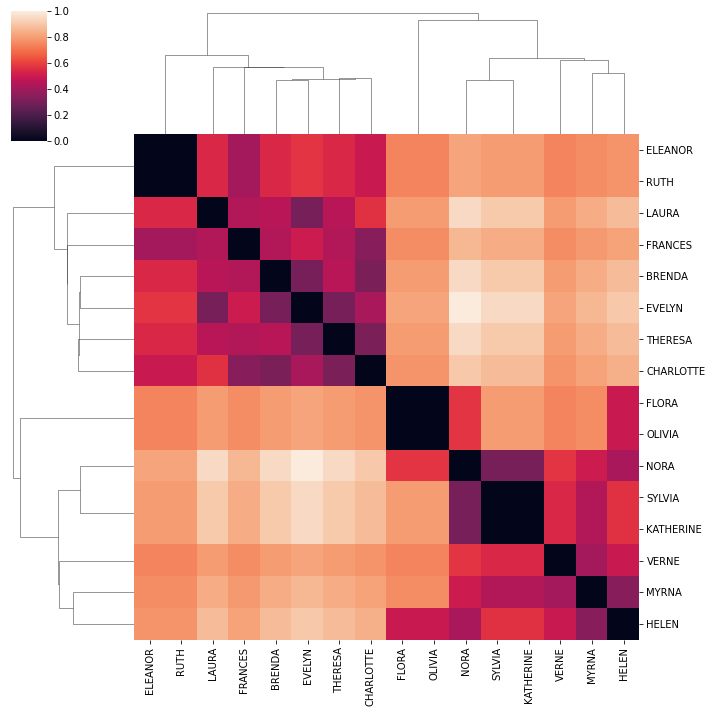

Modified Jaccard distance to Breiger's cliques: 0.0
Modified Jaccard distance to Homans' cliques: 0.0


In [57]:
z_ctr, _ = agglomerative_clustering(d2, method='centroid'
                                    , verbose=1)

d2_sq = squareform(d2)
d2_df = pd.DataFrame(d2_sq, index=women2, columns=women2)
sns.clustermap(d2_df, row_linkage=z_ctr, col_linkage=z_ctr)
plt.show()
evaluate_clustering(z_ctr, women2)

Centroid clustering yields indeed the configuration described by Breiger. 

Polarisation is indeed rather close to $1$, and greater than when using the raw data ($0.68$ vs $0.56$). 

Note that, since we have an even configuration ($8 + 8$), what keeps the polarisation from its maximum is the distance between the two clusters: if the distance were $1$ (the maximum) instead of $0.68$, polarisation would also be $1$. 

In [58]:
0.68/0.68*1

1.0

The reason why the distance between Breiger's disconnected clusters is not maximal in our pipeline comes from the formula of the $\phi$ correlation: indeed, such a lack of connection in Breiger's case only means that the women in question do not share positive attendance values ($f_{11} = 0$), but the actual minimum in $\phi$ (i.e. the maximum in $d$) requires also that $f_{00} = 0$, i.e. that there is no overlap in positive *nor negative* values. Such is rarely the case even with Breiger's configuration, as we can see from $P2$:

In [59]:
P2

array([[1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0],
       [1, 4, 0, 0, 0, 0, 3, 4, 0, 1, 0, 0, 0, 3, 3, 2, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1],
       [0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1],
       [0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1],
       [1, 3, 0, 0, 0, 0, 4, 4, 0, 1, 0, 0, 0, 3, 2, 2, 0, 0],
       [1, 4, 0, 0, 0, 0, 4, 5, 0, 1, 0, 0, 0, 4, 3, 2, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0],
       [0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 4, 4, 2, 0, 0, 0, 2, 4],
       [0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 4, 4, 2, 0, 0, 0, 2, 4],
       [0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 2, 2, 2, 0, 0, 0, 2, 2],
       [1, 3, 0, 0, 0, 0, 3, 4, 0, 1, 0, 0, 0, 4, 3, 2, 0, 0],
       [1, 3, 0, 0, 0, 0, 2, 3, 0, 1, 0, 0, 0, 3, 3, 2, 0, 0],
       [1, 2, 0, 0, 0, 0, 2, 2, 0, 1, 0, 0, 0, 2, 2, 2,